# Strategy recommendation for Airbnb hosts in Seattle
**Nguyen Dang Minh**

* [**Introduction**](#introduction)
* [**Importing libraries and data**](#import)
* [**Data Preprocessing and Feature Engineering**](#preprocessing)
* [**Building model**](#model)
* [**A simple case study**](#case_study)
* [**Conclusions**](#conclusions)

<a id='introduction'></a>

# Introduction

## Seattle and some previous studies

Located in the Eastside, [Seattle](https://en.wikipedia.org/wiki/Seattle) is one of the busiest city in USA. Here lays the headquarter of many giant companies such as **Amazon**, **Microsoft**, **Starbucks**, etc. and big universities such as **University of Washington** and **Seattle University**. The Airbnb business here will therefore likely serve traveller on business trip rather than tourism purpose.

The airbnb data set is a famous open-access dataset that provide informations on the hosts, the booking and review history. There has been many rigorous analysis for another similar dataset: the [Boston airbnb dataset](https://www.kaggle.com/airbnb/boston/kernels). Some examples can be:
* [Insights on the customer booking statistics](https://medium.freecodecamp.org/a-data-driven-story-of-airbnb-25e6c5be8973)
* [Deep analysis on the price distribution, based on locations and apartment properties](https://github.com/ruchigupta19/Boston-Airbnb-data-analysis)
* [Clustering rooms based on owner's descriptions](https://www.kaggle.com/aussie84/clustering-rooms-based-on-owner-s-descriptions)

However, one hole is not yet filled. Reviews, bookings method, or even price, is not the same as **revenue**, and revenue is all that matter in this business. The purpose of this notebook is to analyze the Airbnb data from Jan-2016 to Jan-2017 data and build a model to predict the potential revenue of a new host.

## The business question

### <span style="color:red"> A host is trying to enter the Airbnb business in Seattle, can you provide him/her with a housing and pricing strategy that can maximize the revenue? </span>

### <ins>**How does this help Airbnb?**<ins>
* Maximizing hosts' return means maximizing Airbnb's commision and helps expand the business
* The code can be a core of a recommendation system that suggests pricing and policy for a new-coming host
* The code can be give Airbnb insight information on what category of potential host to reach out for marketing and draw them to the business

## Solutions overview

* **Assumptions:** this problem assume a new-coming hosts, therefore we ignore some historical properties such as host's ratings, previous reviews, properties owned, etc. Properties description and images will not be considered either.
* First we retrieve revenue and booking probability of hosts from the `calendar` file.
* The host properties is categorized into three groups:
    - **House properties**: number of rooms, beds, apartment type, locations, etc.
    - **Host policies**: number of extra guess allowed, cancellation policy, verification from rental, etc, as well as host self-verification
    - **Pricing strategies**: price per person, cleaning fee, price surging over the year, etc.
* A light gradient boosting machine is used with 5-fold cross-validation for revenue predictions

<a id='import'></a>

# Importing libraries and data

## Libraries and settings

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

from utils import *

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Importing data and overview
### Calendar data

In [3]:
calendar_df = pd.read_csv('../input/calendar.csv',parse_dates=['date'])
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
# Calendar data
calendar_df['price'] = calendar_df['price'].apply(lambda x: extract_money(x))
calendar_df['available'] = calendar_df['available'].map({'t':1, 'f':0})
calendar_df['revenue'] = calendar_df['price']*calendar_df['available']

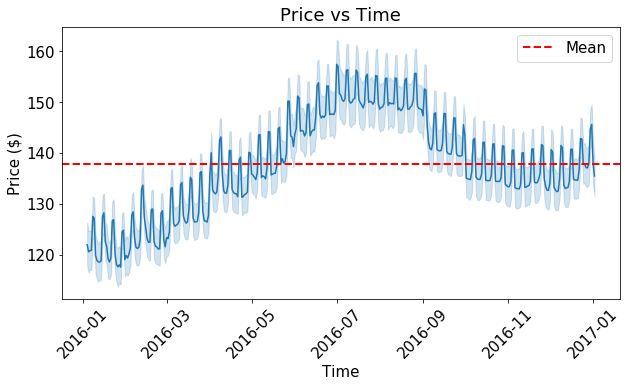

In [5]:
ax = sns.lineplot(x = "date", y = "price", 
                  markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')

<ins>**Observations**:<ins>
* All hosts are existing hosts: i.e. they have all joined before 2016
* The listing information is almost exactly one year (Jan-2016 to Jan-2019)
* The price is on average 140 USD. All the small peaks indicates the weekend period when both demands and price increase.
* The price becomes highest during summer, likely because this is holliday season.
* The price listed in `listings` dataframe is just the lowest price. Prices can be adjusted by the hosts, based on seasons

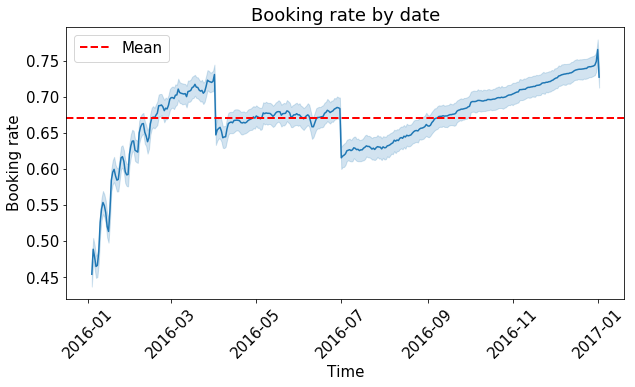

In [6]:
ax = sns.lineplot(x = "date", y = "available", 
                  markers = True, dashes = False, data = calendar_df)
plt.axhline(calendar_df['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')

<ins>**Observations**:<ins>
* Booking rate drop by April (Easter) and July (US Independence Day) where people mostly return and celebrate with family rather than travel
* Booking drop significantly at the beginning and at the end of the year, because of End Year Holliday.

In [7]:
# Calculate financial overview of the booking
calendar_df = calendar_df.fillna(0)
overview = calendar_df.groupby('listing_id')['available','price'].mean()
overview.columns = ['booking_rate(%)', 'daily_revenue']
overview['booking_rate(%)'] = overview['booking_rate(%)']*100

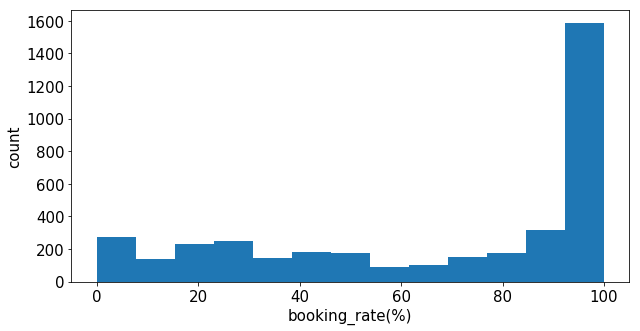

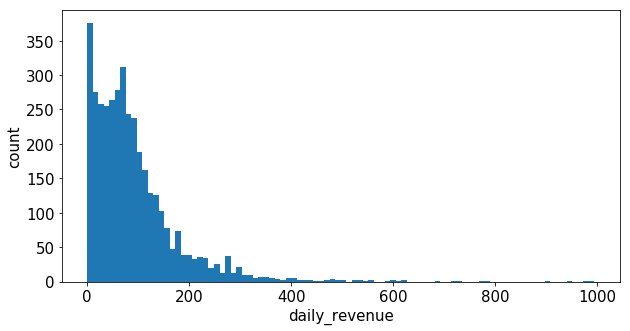

In [8]:
for col in overview.columns:
    plt.figure()
    plt.hist(overview[col], bins='auto')
    plt.xlabel(col)
    plt.ylabel('count')

In [9]:
print('Average daily revenue: %f USD' %np.mean(overview['daily_revenue']))

Average daily revenue: 92.507204 USD


**Observations**:
* Booking rate is in general high. The majority of hosts are fully-booked throughout the year.
* The daily revenue is on average 100 USD/day. Some exeptional case got 1000 USD/day. This can be outliers that cloud our predictions

In [10]:
# Actual average price
calendar_booked = calendar_df[calendar_df['price']!=0]
calendar_booked = calendar_booked.groupby('listing_id').agg({'price':['mean','std']}).reset_index()
calendar_booked.columns=['listing_id','price_avg','price_std']

### Listings data

In [11]:
house_properties = ['bathrooms', 'bedrooms', 'beds', 'room_type', 'accommodates', 'bed_type','property_type','neighbourhood_group_cleansed']
host_policies = ['guests_included','minimum_nights', 'maximum_nights','cancellation_policy','require_guest_phone_verification',
                 'require_guest_profile_picture','host_has_profile_pic', 'host_identity_verified']
pricing_strategies = ['price','cleaning_fee','extra_people']

In [12]:
# Overview
listings_df = pd.read_csv('../input/listings.csv')
useful_cols = ['id'] + house_properties + host_policies + pricing_strategies 
listings_df = listings_df[useful_cols]

In [13]:
# Extract money
for col in pricing_strategies:
    listings_df[col] = listings_df[col].apply(lambda x: extract_money(x))
    
# Merge with calendar data
listings_df = pd.merge(listings_df, overview, how='left', left_on='id', right_on='listing_id')
listings_df = pd.merge(listings_df, calendar_booked, how='left', left_on='id', right_on='listing_id')
listings_df = listings_df.drop(['listing_id'], axis=1)
listings_df['price_per_person'] = listings_df['price']/listings_df['accommodates']
pricing_strategies = pricing_strategies + ['price_avg','price_std', 'price_per_person']

listings_df.head()

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_group_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_rate(%),daily_revenue,price_avg,price_std,price_per_person
0,241032,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,2,1,365,moderate,f,f,t,t,85.0,NaN,5.0,94.794521,80.575342,85.000000,0.000000,21.250000
1,953595,1.0,1.0,1.0,Entire home/apt,4,Real Bed,Apartment,Queen Anne,1,2,90,strict,t,t,t,t,150.0,40.0,0.0,79.726027,136.276712,170.931271,37.225252,37.500000
2,3308979,4.5,5.0,7.0,Entire home/apt,11,Real Bed,House,Queen Anne,10,4,30,strict,f,f,t,t,975.0,300.0,25.0,60.273973,784.657534,1301.818182,356.322687,88.636364
3,7421966,1.0,0.0,2.0,Entire home/apt,3,Real Bed,Apartment,Queen Anne,1,1,1125,flexible,f,f,t,t,100.0,NaN,0.0,39.178082,39.178082,100.000000,0.000000,33.333333
4,278830,2.0,3.0,3.0,Entire home/apt,6,Real Bed,House,Queen Anne,6,1,1125,strict,f,f,t,t,450.0,125.0,15.0,100.000000,462.739726,462.739726,23.703194,75.000000


In [14]:
print_null(listings_df)

bathrooms has 16 null values: 0.421%
bedrooms has 6 null values: 0.157%
beds has 1 null values: 0.026%
property_type has 1 null values: 0.026%
host_has_profile_pic has 2 null values: 0.052%
host_identity_verified has 2 null values: 0.052%
cleaning_fee has 1030 null values: 36.944%
price_avg has 95 null values: 2.552%
price_std has 102 null values: 2.745%


In [15]:
df_test = pd.read_csv('../input/test.csv')
listings_df = pd.concat([listings_df, df_test])
listings_df['revenue_per_guest'] = listings_df['daily_revenue']/listings_df['accommodates']

<a id='preprocessing'></a>

# Data Preprocessing and Feature Engineering

### Data to visualize:
* **Count**: number of hosts with that property
* **Booking rate**: the probability of that host being booked
* **Price per person**: booking price per accomodate
* **Daily revenue**: day-averaged revenue

## House properties

### Bathrooms	, bedrooms, beds, accommodates

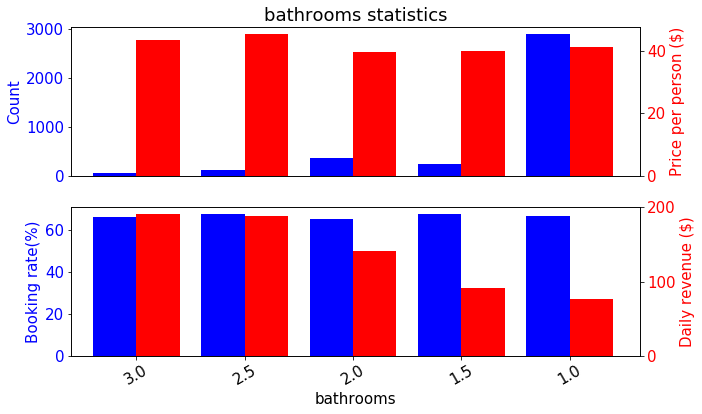

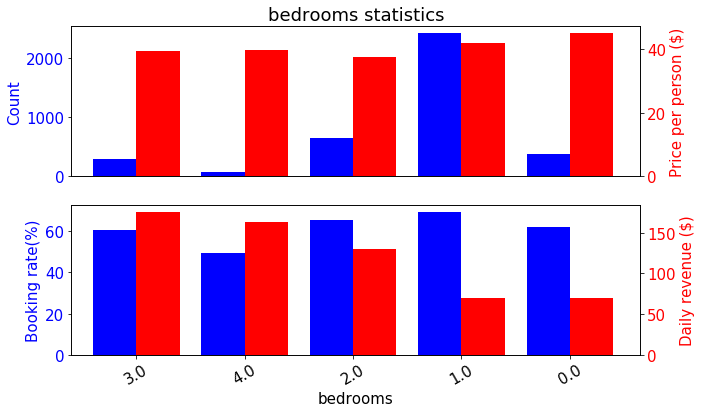

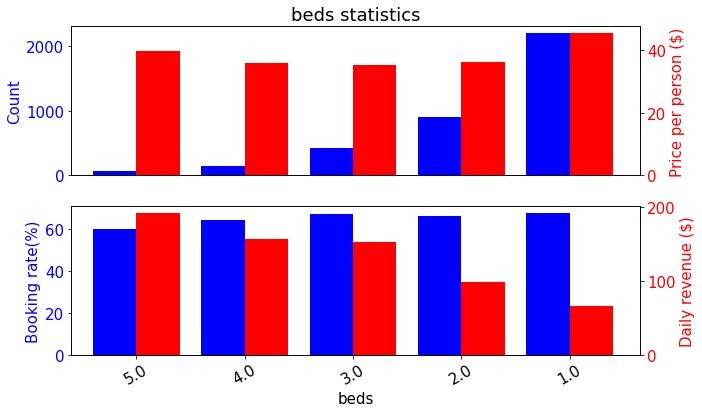

In [17]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    plot_overview(listings_df, col)
    listings_df[col] = impute_na(listings_df, listings_df, col)

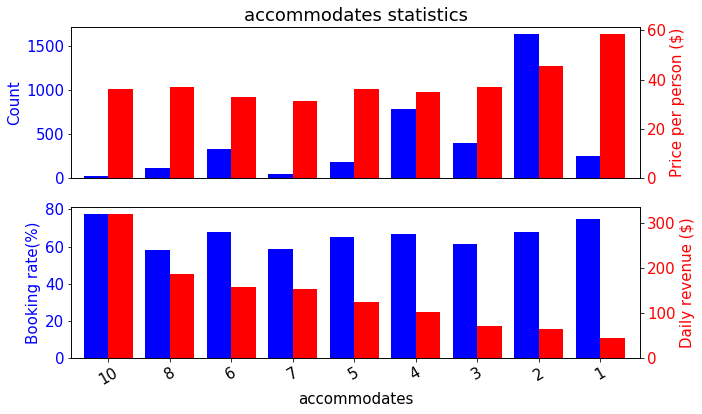

In [18]:
plot_overview(listings_df, 'accommodates',9)

**Observations**
* The majority of Airbnb hosts are smalls with only one bedroom and one beds. They most aim for travellers who are single or coupled.
* However, you can go big. Booking probability does not drop even if you increase in business size. Thus, your revenue increase proportionally.

### Room type, bed type

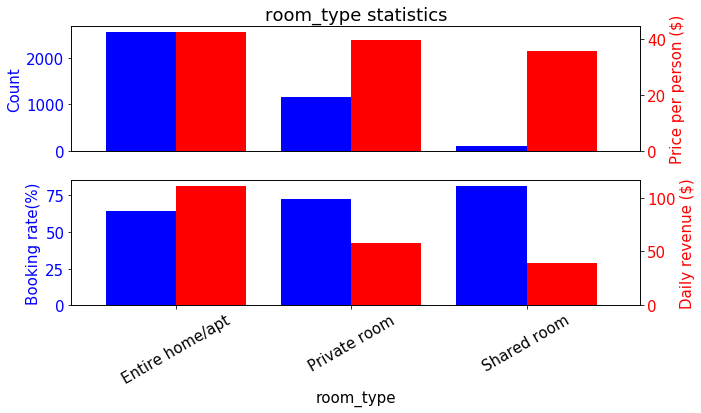

In [19]:
plot_overview(listings_df, 'room_type')
listings_df['room_type']=listings_df['room_type'].replace({'Shared room':0, 'Private room':1, 'Entire home/apt':2})

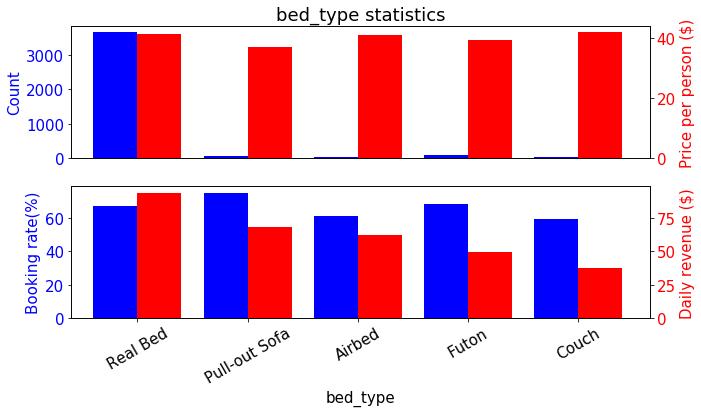

In [20]:
plot_overview(listings_df, 'bed_type')
listings_df['bed_type'] = listings_df['bed_type'].apply(lambda x: 1 if x=='Real Bed' else 0)

<ins>**Observation**<ins>
* Most hosts rent out the whole room/apartment to one booking. Shared room gets you more booking, but lower your revenue.
* A real bed is always wanted and earn you the most money.

### Properties type, neighborhood

In [21]:
def process_property(x):
    if x in ['House','Apartment']:
        return x
    else:
        return 'Other'

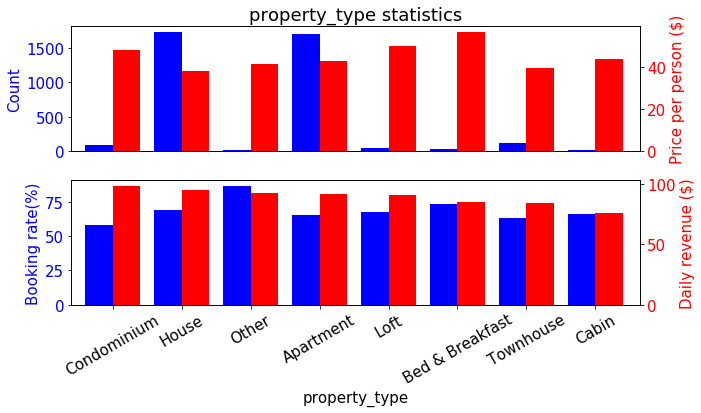

In [22]:
listings_df['property_type'] = impute_na(listings_df, listings_df, 'property_type')
plot_overview(listings_df, 'property_type', 8)
listings_df['property_type'] = listings_df['property_type'].apply(lambda x: process_property(x))

In [23]:
'''
plt.figure(figsize=(10,10))
colormap = plt.cm.RdBu
sns.heatmap(listings_df.groupby([
            'neighbourhood_group_cleansed', 'bedrooms']).daily_revenue.mean().unstack(),annot=True, 
            fmt=".0f",linewidths=0.1,cmap=colormap,linecolor='white')
plt.title('Revenue by district')
'''

'\nplt.figure(figsize=(10,10))\ncolormap = plt.cm.RdBu\nsns.heatmap(listings_df.groupby([\n            \'neighbourhood_group_cleansed\', \'bedrooms\']).daily_revenue.mean().unstack(),annot=True, \n            fmt=".0f",linewidths=0.1,cmap=colormap,linecolor=\'white\')\nplt.title(\'Revenue by district\')\n'

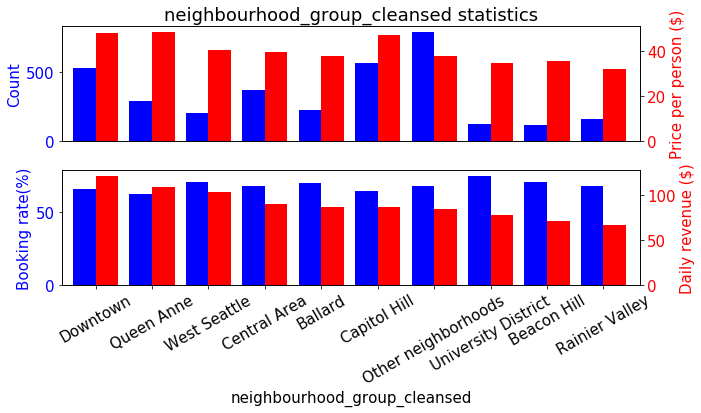

In [24]:
plot_overview(listings_df, 'neighbourhood_group_cleansed', 10)

<ins>**Observations**<ins>:
* Houses and apartments are the most popular type of house
* It's no surpirse that a room in the business area: Downtown or Queenn Anne earn the most money

In [25]:
top_count_neighborhood = listings_df.groupby('neighbourhood_group_cleansed')['id'].count().sort_values(ascending=False).reset_index()
top_count_neighborhood = top_count_neighborhood.loc[:10,'neighbourhood_group_cleansed'].tolist()
listings_df['neighbourhood_group_cleansed'] = listings_df['neighbourhood_group_cleansed'].apply(lambda x: x if x in top_count_neighborhood else 'Other neighborhoods')

## Hosts policy
### Guests included, minimum nights, maximum nights

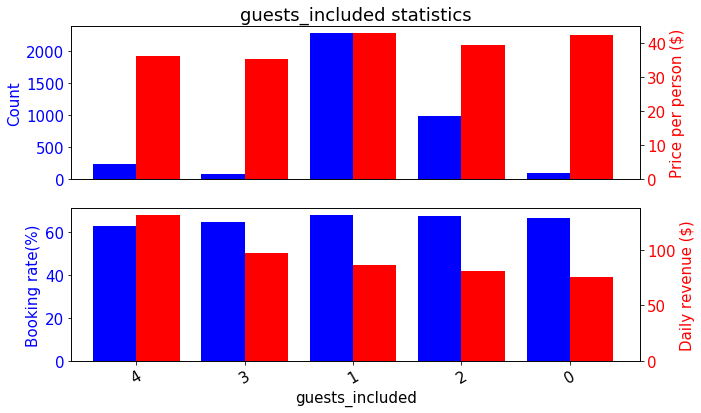

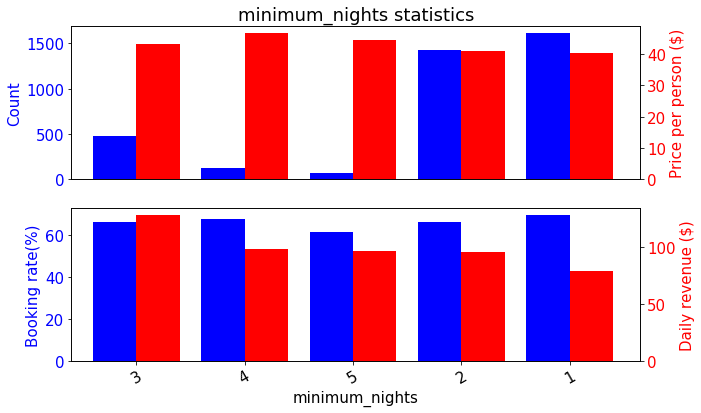

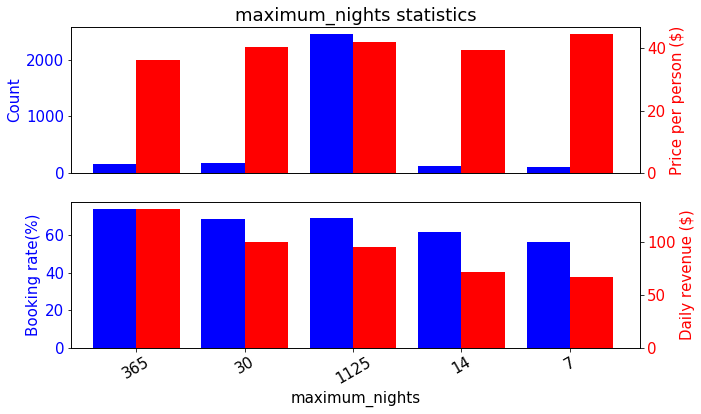

In [26]:
for col in ['guests_included', 'minimum_nights', 'maximum_nights']:
    plot_overview(listings_df, col)

### Cancelation policy, guest verification requirement

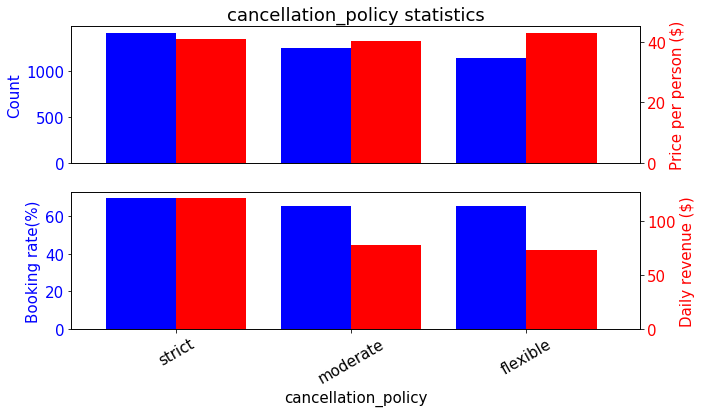

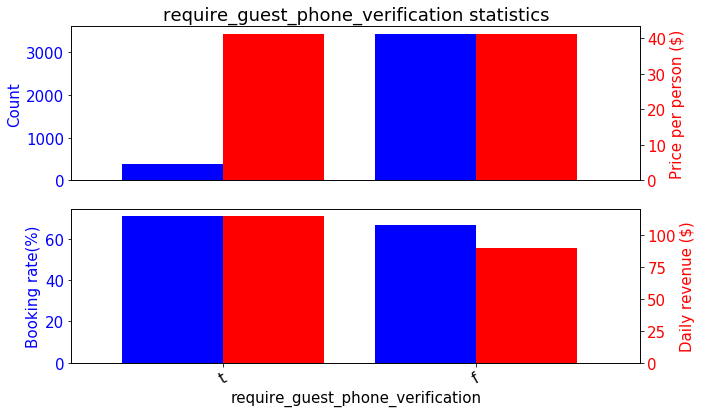

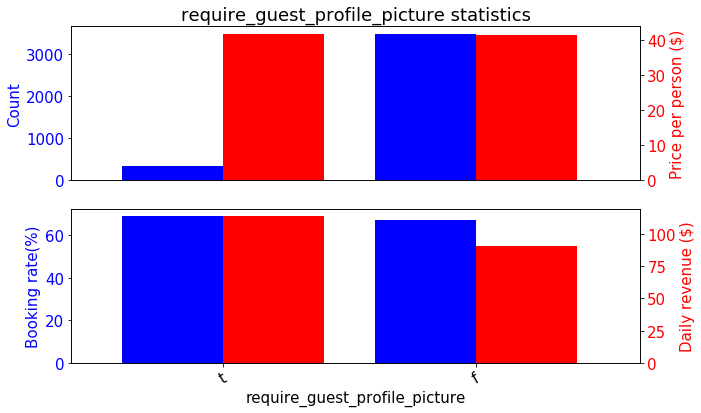

In [27]:
for col in ['cancellation_policy', 'require_guest_phone_verification', 'require_guest_profile_picture']:
    plot_overview(listings_df, col)

<ins>**Observations**<ins>:
* Allowing more guests to be packed increases your revenue
* Letting guests stay for too short (1 day) or ask them to stay too long (5 days) are not good. 3 days are optimum for good revenue.
* Surprisingly, the more strict you are in term of guest verification and cancellation policy, the higher your return. Firstly, this shows that you are serious in the business and earn the trust of the guest. Secondly, you are less likely to get scammed or affected by a sudden change of plan of the guest

In [28]:
listings_df['cancellation_policy'] = listings_df['cancellation_policy'].replace({'strict':2,'moderate':1,'flexible':0})
listings_df['require_guest_phone_verification'] = listings_df['require_guest_phone_verification'].replace({'t':1, 'f':0})
listings_df['require_guest_profile_picture'] = listings_df['require_guest_profile_picture'].replace({'t':1, 'f':0})

### Host properties

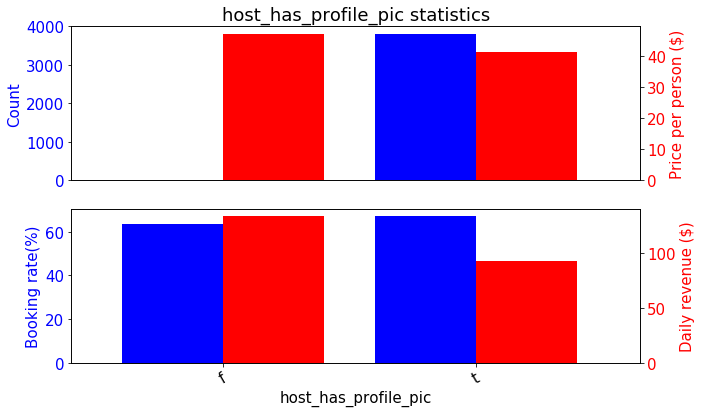

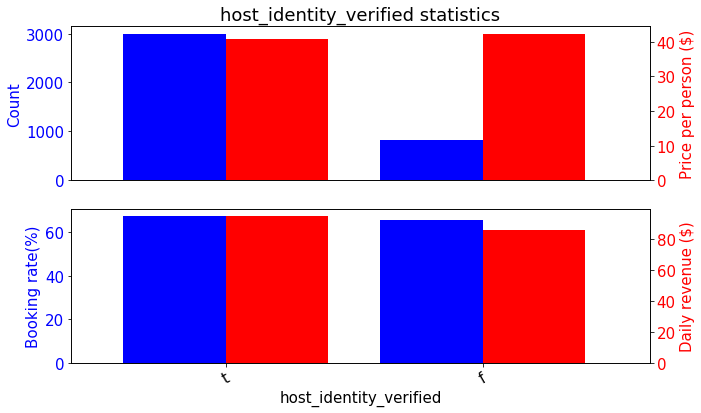

In [29]:
for col in ['host_has_profile_pic', 'host_identity_verified']:
    plot_overview(listings_df, col)
    listings_df[col] = impute_na(listings_df, listings_df, col)
    listings_df[col] = listings_df[col].replace({'t':1,'f':0})

## Pricing strategies

In [30]:
listings_df['cleaning_fee'] = listings_df['cleaning_fee'].fillna(0)
listings_df['price_avg']  = listings_df['price_avg'].fillna(listings_df['price'])
listings_df['price_std'] = listings_df['price_std'].fillna(0)

Text(0.5, 1.0, 'Pair-wise correlation')

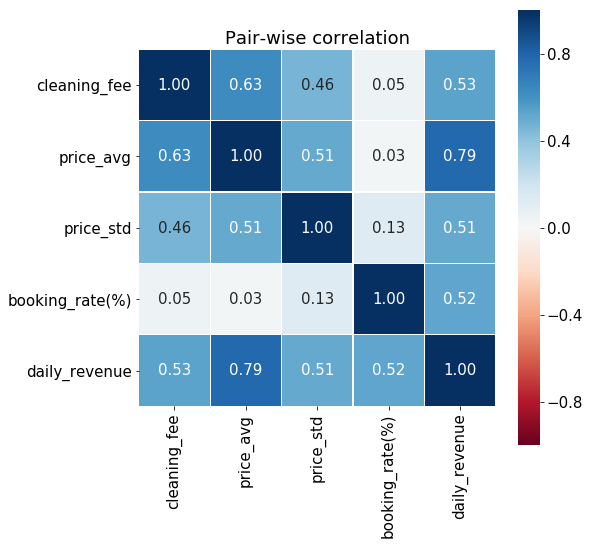

In [31]:
corr_cols = ['cleaning_fee', 'price_avg', 'price_std', 'booking_rate(%)', 'daily_revenue']
colormap = plt.cm.RdBu
plt.figure(figsize=(8,8))
sns.heatmap(listings_df[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

<ins>**Observation**<ins>
* The more you charge money, the higher the revenue (which is trivial)
* The size of the host does not affect your booking probability, i.e. the market is welcoming you, from sharing one of your room to rent out the whole villa.

## Knowledge-based feature

In [32]:
listings_df['accom_per_bed'] = listings_df['accommodates']/listings_df['beds']
listings_df['baths_per_bed'] = listings_df['bathrooms']/listings_df['beds']
listings_df['extra_guest_ratio'] = listings_df['guests_included']/listings_df['accommodates']
listings_df['price_surge_percent'] = (listings_df['price_avg']/listings_df['price']-1)*100
listings_df['price_std_percent'] = listings_df['price_std']/listings_df['price']*100
listings_df['cleaning_fee_percent'] = listings_df['cleaning_fee']/listings_df['price']*100
listings_df['guest_fee_percent'] = listings_df['extra_people']/listings_df['price']*100

## Overall view

In [33]:
corr_cols = ['beds', 'bathrooms', 'accommodates', 'room_type', 'minimum_nights', 'cancellation_policy', 'require_guest_phone_verification', 'host_has_profile_pic', 'extra_guest_ratio',
           'price_surge_percent', 'price_std_percent','price', 'price_per_person', 'booking_rate(%)', 'daily_revenue','revenue_per_guest']

Text(0.5, 1.0, 'Pair-wise correlation')

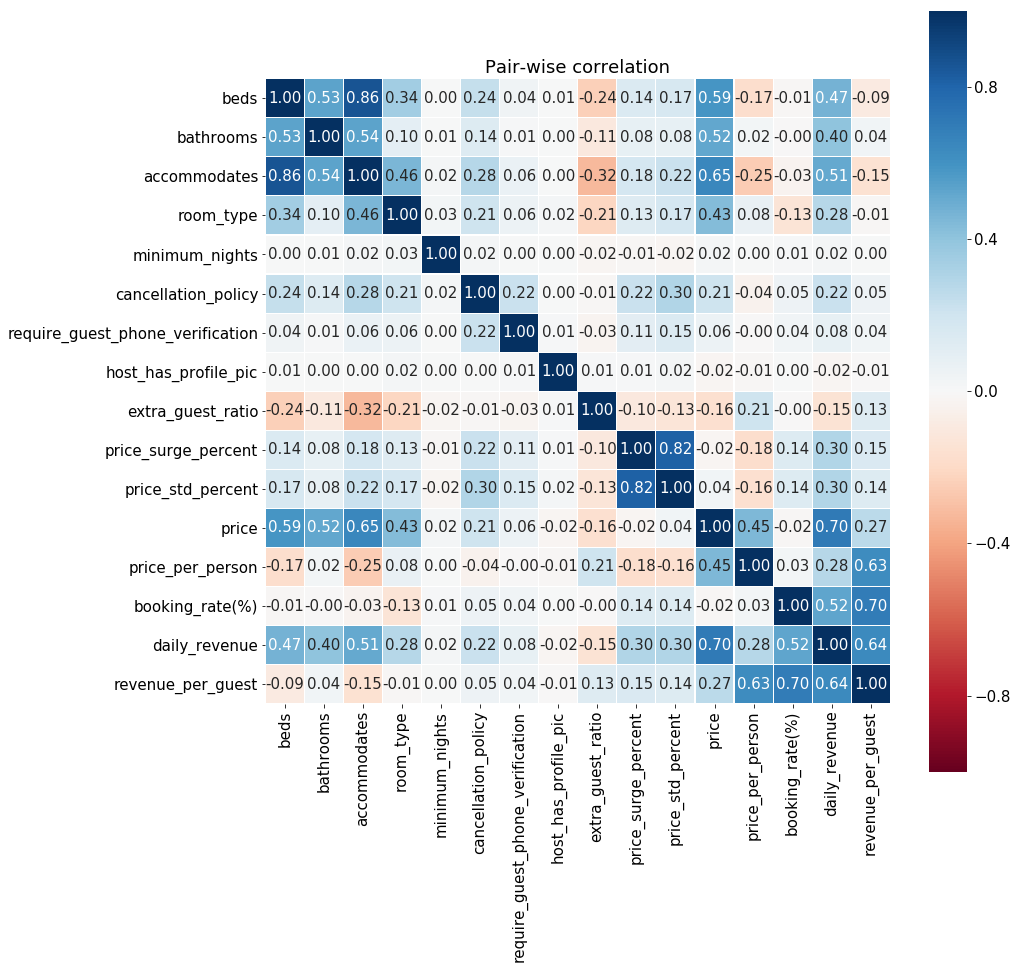

In [34]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
sns.heatmap(listings_df[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')

<ins>**Key observation**<ins>
* Hosts of all size has about the same probability of being booked
* The bigger the business size (more rooms, allowing more guests, etc.), the higher the daily price and the higher your daily revenue. This simply comes from the increase in customer size.
* To actually increase revenue/person/day, the quality of staying needs to be high so that higher price can be charged per person.
* The flexibility/strict level does not have big impact on the revenue.

<a id='model'></a>

# Building model
## Preparing data

In [35]:
#data_train.to_csv('before_one_hot.csv')

In [36]:
# One hot encoding
data_train = listings_df.rename(index=str, columns={'neighbourhood_group_cleansed':'neighborhood'})
data_train = pd.get_dummies(data_train, columns=['property_type','neighborhood'], prefix=['property_type','neighborhood'])

In [37]:
# Standard scaler
# Clipping outliers
for col in ['price', 'daily_revenue']:
    data_train = clipping_outliers(data_train, data_train, col)

There are 42 outliers in price: 0.011%
There are 37 outliers in daily_revenue: 0.010%


In [38]:
data_train.tail(4)

,accommodates,bathrooms,bed_type,bedrooms,beds,booking_rate(%),booking_ratio,cancellation_policy,cleaning_fee,daily_revenue,extra_people,guests_included,host_has_profile_pic,host_identity_verified,id,maximum_nights,minimum_nights,price,price_avg,price_per_person,price_std,require_guest_phone_verification,require_guest_profile_picture,room_type,revenue_per_guest,accom_per_bed,baths_per_bed,extra_guest_ratio,price_surge_percent,price_std_percent,cleaning_fee_percent,guest_fee_percent,property_type_Apartment,property_type_House,property_type_Other,neighborhood_Ballard,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Downtown,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_University District,neighborhood_West Seattle
0,2,1.0,1,1.0,1.0,NaN,NaN,2,20.0,NaN,30.0,1,1,1,Anna,365,2,60.0,80.0,30.0,0.0,1,1,2,NaN,2.0,1.0,0.50,33.333333,0.0,33.333333,50.00,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4,1.0,1,2.0,2.0,NaN,NaN,2,10.0,NaN,15.0,1,1,1,Bob,365,2,80.0,90.0,20.0,0.0,1,1,2,NaN,2.0,0.5,0.25,12.500000,0.0,12.500000,18.75,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,1.0,1,1.0,1.0,NaN,NaN,2,20.0,NaN,30.0,1,1,1,Anna_high,365,2,80.0,110.0,40.0,0.0,1,1,2,NaN,2.0,1.0,0.50,37.500000,0.0,25.000000,37.50,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2,1.0,1,1.0,1.0,NaN,NaN,2,10.0,NaN,15.0,1,1,1,Bob_split,365,2,50.0,60.0,20.0,0.0,1,1,1,NaN,2.0,1.0,0.50,20.000000,0.0,20.000000,30.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [39]:
# Get features and target
unused_cols = ['id', 'booking_rate(%)', 'daily_revenue','price_std', 'revenue_per_guest',
              'price_avg','cleaning_fee', 'extra_people']
features = [col for col in data_train.columns if col not in unused_cols]
train = data_train[features][:-4]
test = data_train[features][-4:]
target_booking = data_train['booking_rate(%)'][:-4]
target_revenue = data_train['daily_revenue'][:-4]
train.to_csv('train.csv')

In [40]:
test.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,booking_ratio,cancellation_policy,guests_included,host_has_profile_pic,host_identity_verified,maximum_nights,minimum_nights,price,price_per_person,require_guest_phone_verification,require_guest_profile_picture,room_type,accom_per_bed,baths_per_bed,extra_guest_ratio,price_surge_percent,price_std_percent,cleaning_fee_percent,guest_fee_percent,property_type_Apartment,property_type_House,property_type_Other,neighborhood_Ballard,neighborhood_Beacon Hill,neighborhood_Capitol Hill,neighborhood_Cascade,neighborhood_Central Area,neighborhood_Downtown,neighborhood_Other neighborhoods,neighborhood_Queen Anne,neighborhood_Rainier Valley,neighborhood_University District,neighborhood_West Seattle
0,2,1.0,1,1.0,1.0,NaN,2,1,1,1,365,2,60.0,30.0,1,1,2,2.0,1.0,0.50,33.333333,0.0,33.333333,50.00,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4,1.0,1,2.0,2.0,NaN,2,1,1,1,365,2,80.0,20.0,1,1,2,2.0,0.5,0.25,12.500000,0.0,12.500000,18.75,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,1.0,1,1.0,1.0,NaN,2,1,1,1,365,2,80.0,40.0,1,1,2,2.0,1.0,0.50,37.500000,0.0,25.000000,37.50,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2,1.0,1,1.0,1.0,NaN,2,1,1,1,365,2,50.0,20.0,1,1,1,2.0,1.0,0.50,20.000000,0.0,20.000000,30.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0


## Modelling

### Hyperparameters tuning

In [41]:
'''
parameters = {'num_leaves':np.arange(30,120,1),
             'max_depth':[7,8,9,10],
             'min_child_sample': np.arange(15,80,1),
             'reg_lambda':np.arange(0.1,0.5,0.01)}
fit_params = {'verbose':500}
grid_search = RandomizedSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(train[features], target_revenue, **fit_params)
'''

"\nparameters = {'num_leaves':np.arange(30,120,1),\n             'max_depth':[7,8,9,10],\n             'min_child_sample': np.arange(15,80,1),\n             'reg_lambda':np.arange(0.1,0.5,0.01)}\nfit_params = {'verbose':500}\ngrid_search = RandomizedSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')\ngrid_search.fit(train[features], target_revenue, **fit_params)\n"

### Fittting

In [42]:
# Input parameters
ITERATIONS = 5000
N_FOLDS = 5

In [43]:
model_revenue = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

model_booking = lgb.LGBMRegressor(num_leaves=50,
                        max_depth=10,
                        learning_rate=0.005,
                        n_estimators=ITERATIONS,
                        min_child_samples=25,
                        subsample=0.75,
                        subsample_freq=1,
                        feature_fraction=0.75,
                        reg_lambda=0.2,
                        random_state=2019,
                        n_jobs=4,
                        metrics='mae')

In [44]:
# Preparing for out of fold training
oof_train = np.zeros(shape=(len(train)))

## Training
### Booking probability

In [45]:
# Training for revenue
print('TRAINING FOR REVENUE')
feature_importance_df_booking = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_booking.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_booking.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_booking.iloc[val_idx]
    model_booking.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_booking.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_booking.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_booking = pd.concat([feature_importance_df_booking, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_booking)
print('Training CV score: %.5f' %score)

TRAINING FOR REVENUE
Fold no 1/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 23.9613	valid_1's l1: 27.8787
[1000]	training's l1: 20.8436	valid_1's l1: 27.0544
[1500]	training's l1: 18.7174	valid_1's l1: 26.6964
[2000]	training's l1: 17.0405	valid_1's l1: 26.5697
Early stopping, best iteration is:
[2325]	training's l1: 16.0809	valid_1's l1: 26.5427
Fold no 2/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 24.3124	valid_1's l1: 27.8666
[1000]	training's l1: 21.1858	valid_1's l1: 26.9076
[1500]	training's l1: 18.9713	valid_1's l1: 26.5613
[2000]	training's l1: 17.2385	valid_1's l1: 26.421
Early stopping, best iteration is:
[2338]	training's l1: 16.2235	valid_1's l1: 26.3416
Fold no 3/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 24.1267	valid_1's l1: 27.402
[1000]	training's l1: 20.9432	valid_1's l1: 26.7423
[1500]	training's l1: 18.7596	valid_1's l1: 26.5649
Early stoppin

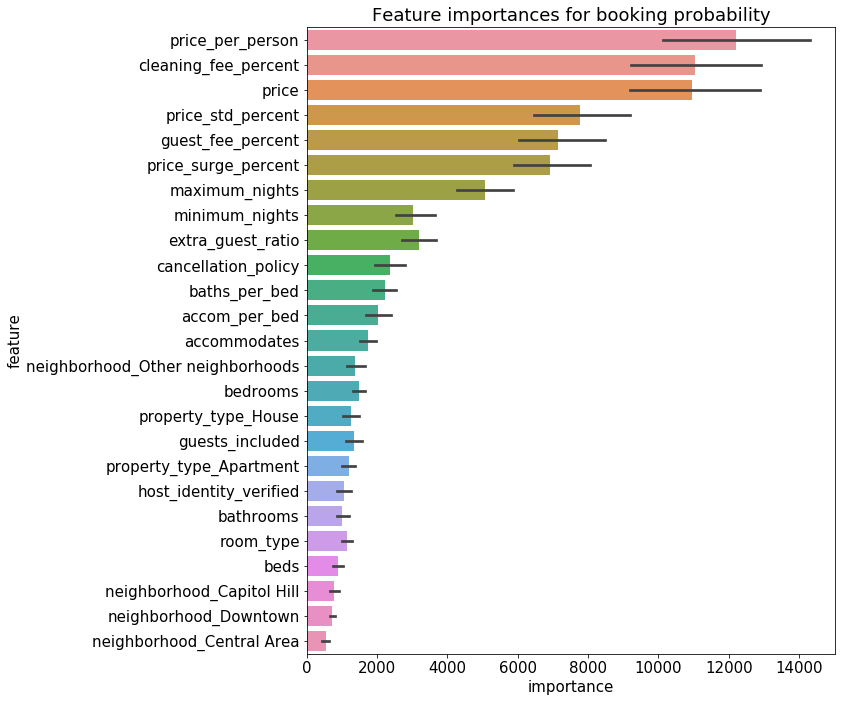

In [46]:
# Visualization
cols = (feature_importance_df_booking[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_booking.loc[feature_importance_df_booking.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for booking probability')
plt.tight_layout()

### Revenue

In [47]:
# Training for revenue
print('TRAINING FOR BOOKING')
feature_importance_df_revenue = pd.DataFrame()
folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target_revenue.values)):
    print('Fold no %i/%i'%(fold_+1,N_FOLDS))
    trn_data = train.iloc[trn_idx][features]
    trn_label = target_revenue.iloc[trn_idx]
    val_data = train.iloc[val_idx][features]
    val_label = target_revenue.iloc[val_idx]
    model_revenue.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=500,
                     early_stopping_rounds=100)

    oof_train[val_idx] = model_revenue.predict(val_data)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model_revenue.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_revenue = pd.concat([feature_importance_df_revenue, fold_importance_df], axis=0)

score = mean_absolute_error(oof_train[:], target_revenue)
print('Training CV score: %.5f' %score)

TRAINING FOR BOOKING
Fold no 1/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 32.3925	valid_1's l1: 37.5837
[1000]	training's l1: 28.5507	valid_1's l1: 36.1095
[1500]	training's l1: 26.1162	valid_1's l1: 35.763
[2000]	training's l1: 24.2093	valid_1's l1: 35.6327
Early stopping, best iteration is:
[1947]	training's l1: 24.3815	valid_1's l1: 35.6252
Fold no 2/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 32.1822	valid_1's l1: 38.172
[1000]	training's l1: 28.2947	valid_1's l1: 36.825
[1500]	training's l1: 25.9313	valid_1's l1: 36.2809
[2000]	training's l1: 24.026	valid_1's l1: 35.9683
[2500]	training's l1: 22.4728	valid_1's l1: 35.8004
Early stopping, best iteration is:
[2771]	training's l1: 21.6904	valid_1's l1: 35.7392
Fold no 3/5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 32.5089	valid_1's l1: 37.4794
[1000]	training's l1: 28.5277	valid_1's l1: 36.0986
[1500]	training

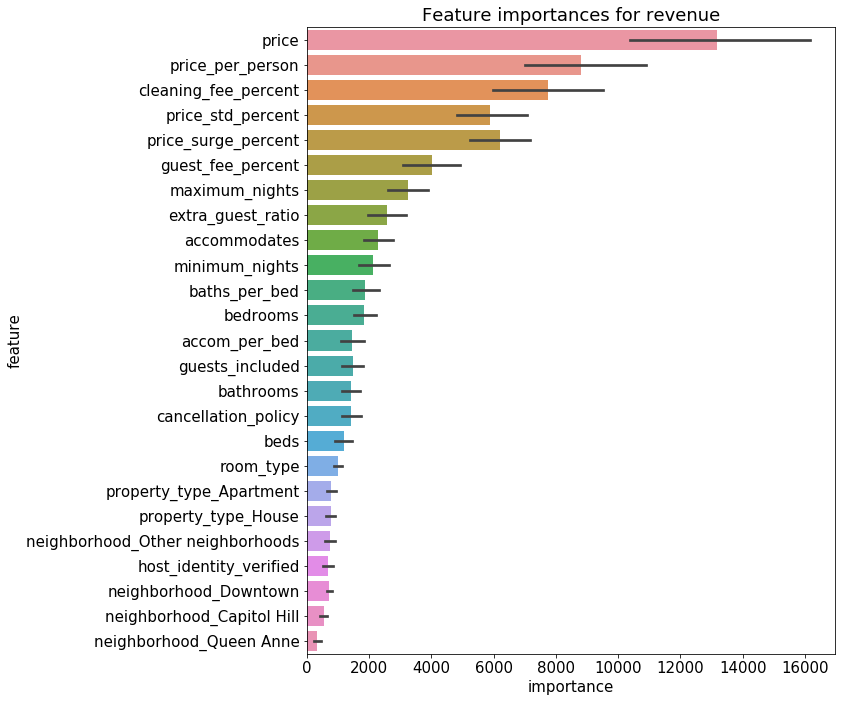

In [48]:
# Visualization
cols = (feature_importance_df_revenue[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:25].index)

best_features = feature_importance_df_revenue.loc[feature_importance_df_revenue.feature.isin(cols)]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('Feature importances for revenue')
plt.tight_layout()

<ins>**Observation**<ins>
* Pricing strategy plays the dominant role in the success of the business. The higher the price, cleaning fee, or extra charge in peaks seasons help improve revenue
* The higher the business size (accommodations, guests), the better the revenue
* Surprisingly, neighborhood and type of house/apartment does not play a significant role.

<a id='case_study'></a>


# A simple case study
## The scenario

Let's consider a simple case. Assuming we have a happy couple living in Seatle: Anna and Bob. Anna is an data analyst, she has a one-room apartment in Downtown district. Bob is a math lecturer who has a two-bedroom apartment in University district. Soon they will move in together into one apartment and rent out the other via Airbnb. But should Anna move in with Bob and leave her room for rent or should it be the other way? Our model can assist them to make the best decision.

<img src="../images/case_study.png" width="600px" >

Being in good location, Anna wants to charge higher price per person, with extra cleaning fee and sur-charge during weekend or peek season. Bob, on the other hand, charge lower price per person since he think his guest will most likely be student. Still, being the larger apartment, he still gets higher overall price. We create a test data with this assumption and predict potential revenue based on our model.

In [49]:
df_test.head(2)

,id,bathrooms,bedrooms,beds,room_type,accommodates,bed_type,property_type,neighbourhood_group_cleansed,guests_included,minimum_nights,maximum_nights,cancellation_policy,require_guest_phone_verification,require_guest_profile_picture,host_has_profile_pic,host_identity_verified,price,cleaning_fee,extra_people,booking_ratio,daily_revenue,price_avg,price_per_person
0,Anna,1,1,1,Entire home/apt,2,Real Bed,Apartment,Downtown,1,2,365,strict,t,t,t,t,60,20,30,NaN,NaN,80,30
1,Bob,1,2,2,Entire home/apt,4,Real Bed,Apartment,University District,1,2,365,strict,t,t,t,t,80,10,15,NaN,NaN,90,20


In [50]:
test_pred = pd.DataFrame()
test_pred[['id','bedrooms','neighbourhood','room_type','price']] = df_test[['id','bedrooms','neighbourhood_group_cleansed','room_type','price']]
test_pred['Daily revenue'] = model_revenue.predict(test)
test_pred['Booking rate (%)'] = model_booking.predict(test)

In [51]:
test_pred.head(2)

,id,bedrooms,neighbourhood,room_type,price,Daily revenue,Booking rate (%)
0,Anna,1,Downtown,Entire home/apt,60,26.183075,37.107138
1,Bob,2,University District,Entire home/apt,80,53.129255,59.944435


The price proposed by Anna might be too expensive. Bob has more customers and higher return. **They should rent out Bob's apartment and move to Anna's**

## Change of plan

Anna is thinking about making a renovation, installing bathtub, upgrading internet and tv cable. With this she hopes that the apartment is of higher value and can charge more. How much can she earn from that?

In [52]:
test_pred.loc[[0,2],:]

,id,bedrooms,neighbourhood,room_type,price,Daily revenue,Booking rate (%)
0,Anna,1,Downtown,Entire home/apt,60,26.183075,37.107138
2,Anna_high,1,Downtown,Entire home/apt,80,42.842814,40.558046


Yes, by improving the room quality, Anna can attract more customers, charge higher price and get higher return, but still lower than that of Bob

Bob has another plan for his apartment. Instead of renting out as a whole, he wants to split it into two separate rooms and rent out separately. How does this help?

In [53]:
test_pred.loc[[1,3],:]

,id,bedrooms,neighbourhood,room_type,price,Daily revenue,Booking rate (%)
1,Bob,2,University District,Entire home/apt,80,53.129255,59.944435
3,Bob_split,1,University District,Private room,50,25.964418,49.901021


Should Bob chooses to rent out the room separately, even though the price per person increases, he gets a significant drop in booking probability (20% drop). Probably people prefer to rent the whole apartment rather than just a room. Splitting here is a no-no.

<a id='conclusions'></a>


# Conclusions

## About the data

* Pricing strategies has the biggest impact on overall revenue. The higher the price per person (maybe from better position, rooms quality), the higher the revenue
* The majority of current hosts are small owner. However, opportunities are there for hosts of all kind of sizes, from small apartment to big houses. The size of your business should not affect your booking probability.
* Be stricts on cancellation policy and guests information, it does help.

## About the code

* The EDA part provide overview about Airbnb market in Seattle.
* The model can assist customer predict the potential return to choose the right rental plan and pricing strategy.
* This analysis can be a recommendation tool for Airbnb and also helps them identify potential hosts that can maximize revenue.

## Limitations to be improved

* No images/description is considered, thus a large amount of information regardings the house's properties is neglected.
* The current model is not possible to tell the difference between a high price/person due to high room quality and a high price/person due to overpricing.
* The model is used for incomming hosts, but data is taken from existing, may even be highly experienced hosts. This mismatch can lead to inaccuracy in prediction